#### Warm Up | Master's Thesis
# HEISENBERG MODEL IN NETKET

We look again at the spin $1/2$ Heisenberg model. This is an antiferromagnetic spin chain, meaning that its spins are anti-aligned ($...\uparrow \downarrow \uparrow \downarrow \uparrow ...$). We have a generic Hamiltonian of the form:

$$
H = \sum_{i=1}^{L} \vec{\sigma}_{i} \cdot \vec{\sigma}_{i+1} = \sum_{i=1}^L\left(\sigma_i^x \sigma_{i+1}^x+\sigma_i^y \sigma_{i+1}^y+\sigma_i^z \sigma_{i+1}^z\right)
$$


The Pauli matrices $\sigma^x$, $\sigma^y$, and $\sigma^z$ represent twice the actual spin-$\frac{1}{2}$ operators, which are given by:

$$
\hat{S}^x = \frac{1}{2} \sigma^x, \quad \hat{S}^y = \frac{1}{2} \sigma^y, \quad \hat{S}^z = \frac{1}{2} \sigma^z
$$

Therefore, in terms of spin operators, the Hamiltonian gains a factor of 4:

$$
H = 4 \sum_{i=1}^{L} \vec{S}_{i} \cdot \vec{S}_{i+1}
$$

The goal here is to learn the ground-state of this model using a Restricted Boltzmann Machine (RBM).

#### SETUP

The `NetKet` library uses `Jax` as backbone. We want to make sure to run `Jax` on the CPU. For systems with less than 40 spins, GPUs will slow down everything remarkably.



In [14]:
import os

import netket as nk

import json

import numpy as np
import matplotlib.pyplot as plt
import time

os.environ["JAX_PLATFORM_NAME"] = "cpu"

`NetKet` starts off by defining the spin-chain as a graph. In this case a one-dimensional hypercube with periodic boundary conditions.

In a second step, we define the Hilbert space on this graph.

We impose a fixed total magnetization of zero since the up-spins balance out the down spins.
This restricts the Hilbert space to only the spin configurations fulfilling this constraint. This can be expressed with the binomial coefficient:

$$
\text{dim}(\text{Hilbert space}) = \binom{L}{L/2}
$$

This binomial coefficient gives a much smaller Hilbert space than taking all $2^L$ possible spin configurations into account.

In a third step, the graph of the system and the Hilbert space are then used to define the Hamiltonian acting in this Hilbert space. `NetKet` provides a Hamiltonian class for the Heisenberg model which uses Pauli matrices internally.

In [15]:
L = 22
g = nk.graph.Hypercube(length=L, n_dim=1, pbc=True)
hi = nk.hilbert.Spin(s=0.5, total_sz=0, N=g.n_nodes)
ha = nk.operator.Heisenberg(hilbert=hi, graph=g)

#### EXACT DIAGONALIZATION

Just like with the example of the Heisenberg model in the QST warm-up, we want to perform an exact diagonalization. `NetKet` should still be able to do this brute-force for $L=22$ using the Lanczos algorithm.

We only need the lowest energy and are not interested in the eigenvectors.


**Intermezzo: Lanczos Algorithm**

The primary aim is to find the ground state energy (lowest eigenvalue) and possibly a few low-energy excited states of the Heisenberg Hamiltonian.

The Lanczos algorithm involves the following steps:

- 1. **Choose an initial vector** $v_0$ (random or physically motivated, e.g., a Néel state for an antiferromagnetic system).

2. **Iteratively build the Krylov subspace** by applying the Hamiltonian $H$ to generate new orthonormal vectors:

   - Apply $H$ to the current vector $v_i$:
     $$
     w_{i+1} = H v_i - \beta_i v_{i-1} - \alpha_i v_i
     $$

   - Compute the coefficients:
     $$
     \alpha_i = \langle v_i | H | v_i \rangle, \quad \beta_{i+1} = \|w_{i+1}\|
     $$

   - Normalize to get the next vector:
     $$
     v_{i+1} = \frac{w_{i+1}}{\beta_{i+1}}
     $$

3. **Ensure orthogonality** of $v_{i+1}$ by subtracting components along $v_i$ and $v_{i-1}$, ensuring $w_{i+1}$ is orthogonal to all previous vectors.

4. **Form the tridiagonal matrix $T_m$**:

   - At each iteration, add the new diagonal element $\alpha_i$ and off-diagonal element $\beta_i$ to $T_m$.

   - The tridiagonal matrix $T_m$ encodes how the Hamiltonian $H$ acts on the **Krylov subspace**, which is the span of the vectors encoding higher powers of $H$ applied to the initial vector $v_0$:
     $$
     \mathcal{K}_m(H, v_0) = \text{span}\{v_0, H v_0, H^2 v_0, \ldots, H^{m-1} v_0\}
     $$

   - This subspace captures the dominant behavior of the Hamiltonian by approximating its action through repeated powers of H$. This is similar to how polynomial expansions approximate functions or how PCA finds principal components that span the most important directions in data.

   - After $m$ iterations, the matrix $T_m$ looks something like this:

     $$
     T_m =
     \begin{bmatrix}
     \alpha_0 & \beta_1 & 0 & \cdots & 0 \\
     \beta_1 & \alpha_1 & \beta_2 & \cdots & 0 \\
     0 & \beta_2 & \alpha_2 & \cdots & 0 \\
     \vdots & \vdots & \vdots & \ddots & \beta_{m-1} \\
     0 & 0 & 0 & \beta_{m-1} & \alpha_{m-1}
     \end{bmatrix}
     $$

5. **Solve the eigenvalue problem for $T_m$**:

   - Since $T_m$ is a small symmetric tridiagonal matrix (size $m \times m$, where $m \ll 2^N$), solving for its eigenvalues is computationally much easier than diagonalizing the full Hamiltonian $H$.
   - The smallest eigenvalue of $T_m$ approximates the **ground state energy**, and higher eigenvalues correspond to low-energy excitations.


In [16]:
# this took about half a minute on my M1 MacBook, run the next cell if you don't want to wait

evals = nk.exact.lanczos_ed(ha, compute_eigenvectors=False)
exact_gs_energy = evals[0]
print('The exact ground-state energy is E0=',exact_gs_energy)

The exact ground-state energy is E0= -39.1475226070629


In [9]:
exact_gs_energy = -39.14752260706279

#### SIMULATING EVOLUTION INTO THE GROUND STATE

The Lanczos algorithm is just a mathematical approximation of the exact diagonalization. Since we are dealing with a physical system, we can also simulate the evolution of the system into the ground state using a variational Monte Carlo (VMC) method.



## 3. The Jastrow ansatz

Let's start with a simple ansatz for the ground-state: the Jastrow Ansatz.

$ \log\psi(\sigma) = \sum_i a_i \sigma_i + \sum_{i,j} \sigma_i J_{i,j} \sigma_j $

To show how it's done, we write this simple ansatz as a `flax.linen` module. 
We import this module and call it `nn`, as it is customary in all `Flax` documentation.

You should define a function in the module called `__call__` and decorated with `@nn.compact`. This function is responsible for defining the flow of your model, that is, to evaluate the module for a batch of inputs.

Parameters in the module are specified by calling `self.param(parameter_name, initializer, shape, dtype)`. The first argument is an arbitrary string, the second should be an initializer from `nn.initializers` and the other two are shape and dtype of that parameter.

As the module should work with batches of inputs (therefore the input will be a 2d matrix with shape `(N_inputs, N_sites)`, but we are lazy and find it easier to define the function for a single input $\sigma$, a 1D vector of shape `(N_sites,)`. 
Therefore, we write a function called `evaluate_single`, which will evaluate a single 1D input, and use `jax.vmap` to make it work with 2D inputs as well.

To learn more about jax.vmap, give a look at the jax documentation!

In [18]:
import flax.linen as nn
import jax.numpy as jnp
import jax

class Jastrow(nn.Module):
    @nn.compact
    def __call__(self, x):
        # sometimes we call this function with a 1D input, sometimes with a 2D.
        # We promote all inputs to 2D to make the following code simpler.
        x = jnp.atleast_2d(x)
        # We vmap along the 0-th axis of the input
        # This will automatically convert a function working on vectors to one working
        # on matrices.
        return jax.vmap(self.evaluate_single, in_axes=(0))(x)
        
    def evaluate_single(self, x):
        # We create the parameter v, which is a vector of length N_sites 
        v_bias = self.param(
            "visible_bias", nn.initializers.normal(), (x.shape[-1],), complex
        )
    
        # The Jastrow matrix is a N_sites x N_sites complex-valued matrix
        J = self.param(
            "kernel", nn.initializers.normal(), (x.shape[-1],x.shape[-1]), complex
        )
        
        # In python @ symbolises matrix multiplication
        return x.T@J@x + jnp.dot(x, v_bias)

Now that the model is defined, we can instantiate it

In [19]:
ma = Jastrow()
print(ma)

Jastrow()


In [20]:
# Build the sampler
sa = nk.sampler.MetropolisExchange(hilbert=hi,graph=g)

# Optimizer
op = nk.optimizer.Sgd(learning_rate=0.01)

# Stochastic Reconfiguration
sr = nk.optimizer.SR(diag_shift=0.1, holomorphic=True)

# The variational state
vs = nk.vqs.MCState(sa, ma, n_samples=1008)

# The ground-state optimization loop
gs = nk.VMC(
    hamiltonian=ha,
    optimizer=op,
    preconditioner=sr,
    variational_state=vs)

start = time.time()
gs.run(300, out='Jastrow')
end = time.time()

print('### Jastrow calculation')
print('Has',nk.jax.tree_size(vs.parameters),'parameters')
print('The Jastrow calculation took',end-start,'seconds')

  0%|          | 0/300 [00:00<?, ?it/s]

### Jastrow calculation
Has 506 parameters
The Jastrow calculation took 16.361618041992188 seconds


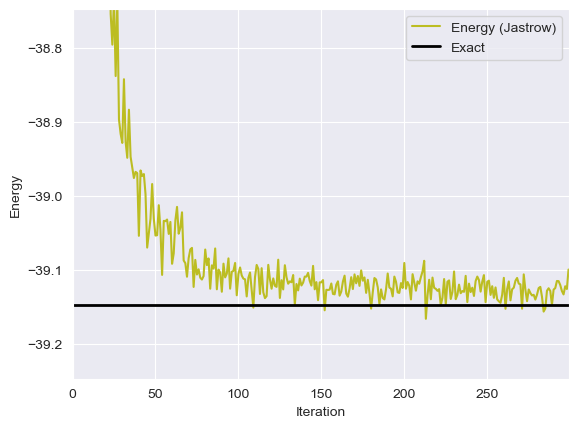

In [21]:
# import the data from log file
data_Jastrow=json.load(open("Jastrow.log"))
   
iters_Jastrow = data_Jastrow["Energy"]["iters"]
energy_Jastrow = data_Jastrow["Energy"]["Mean"]["real"]

fig, ax1 = plt.subplots()
ax1.plot(iters_Jastrow, energy_Jastrow, color='C8', label='Energy (Jastrow)')
ax1.set_ylabel('Energy')
ax1.set_xlabel('Iteration')
plt.axis([0,iters_Jastrow[-1],exact_gs_energy-0.1,exact_gs_energy+0.4])
plt.axhline(y=exact_gs_energy, xmin=0,
                xmax=iters_Jastrow[-1], linewidth=2, color='k', label='Exact')
ax1.legend()
plt.show()